# COVID-19 日本における感染者数の推移予測
元データは[WHO発表](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports)より作成。

## 必要なライブラリの読み込み
使用するライブラリは
- pandas : 表データの扱い
- numpy : 数値計算
- matplotlib : グラフを描く
- scipy : 近似用

_import_ で読み込み。_as_ を付けることで、後のコード中でその名前でライブラリに含まれる関数を使うことができる。

_from ライブラリ名 import 関数名_ 句を使うと、巨大なライブラリから特定の関数だけ抜き出して使うことができる。

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

まずは、csvデータからの読み込み。pandasのdataframe型になる。

In [133]:
df = pd.read_csv("COVID_2019.csv")
#df = df[:len(df.Japan.dropna())]
df = pd.concat([pd.to_datetime(df["date"]), df.Japan, df.China, df.Korea, df.Singapore, df.Italy, df.Germany, df.France, df.USA], axis=1)

df

,date,Japan,China,Korea,Singapore,Italy,Germany,France,USA
0,2020-01-21,1.0,278.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-22,1.0,309.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-23,1.0,571.0,1.0,0.0,0.0,0.0,0.0,1.0
3,2020-01-24,1.0,831.0,2.0,1.0,0.0,0.0,0.0,1.0
4,2020-01-25,3.0,1297.0,2.0,3.0,0.0,0.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...
223,2020-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,2020-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,2020-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,2020-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


グラフを描画

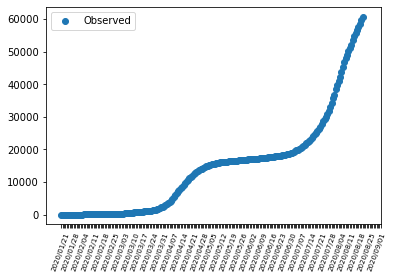

In [134]:
plt.scatter(range(len(df.date)), df.Japan.values, label="Observed")
xjticks = [l.strftime("%Y/%m/%d") if i%7==0 else "" for i,l in enumerate(df.date)]
plt.xticks(range(len(df.date)), xjticks, fontsize=7, rotation=70);
plt.legend()

渡された次数に応じて数式の文字列を作る関数を作成。

In [135]:
def gen_eq_str(coefficients:list, x:str="x", y:str="y"):
    s = ""
    if len(coefficients) == 0:
        s += " 0"
    else:
        for i, coef in enumerate(coefficients):
            if i == len(coefficients) - 1:
                s += " {} {:.2f}".format("+" if coef>0 else "-", np.abs(coef))
            elif i == len(coefficients) - 2:
                s += " {} {:.2f} {}".format("+" if coef>0 else "-", np.abs(coef), x)
            else:
                s += " {} {:.2f} {}^{}".format("+" if coef>0 else "-", np.abs(coef), x, len(coefficients)-i-1)
    if s[1] == "+":
        s = s[2:]
    return "{} ={}".format(y, s)

print(gen_eq_str([-2]))
print(gen_eq_str([1, -2], y="z"))
print(gen_eq_str([5, -6, -7], x="t"))

y = - 2.00
z = 1.00 x - 2.00
y = 5.00 t^2 - 6.00 t - 7.00


渡されたデータ列に対して、指定された範囲で近似曲線を描画する関数を作成。

In [136]:
def draw_approx_curve(x_data:np.ndarray, y_data:np.ndarray, r:range, 
    deg:int, forecast:int=14, color:str="green", info:str=""):
    x = [x_data[i] for i in r] - x_data[r.start]
    y = [y_data[i] for i in r] - y_data[r.start]
    coef = np.polyfit(x, y, deg)
    coef[deg] += y_data[r.start]
    x_f = [x_data[i] for i in range(r.start, r.stop + r.step * forecast, r.step)]
    curve = np.poly1d(coef)(x_f - x_data[r.start])
    label = gen_eq_str(coef, x="t")
    label = label[:label.rfind("t")+1]  # omit intercept
    plt.plot(x_f, curve, c=color, label="{} {}".format(label, info))

指数関数用の近似曲線を描画する関数

In [137]:
def draw_approx_exp_curve(x_data:np.ndarray, y_data:np.ndarray, r:range, 
    forecast:int=14, color:str="green", info:str=""):
    x = [x_data[i] for i in r] - x_data[r.start]
    y = [y_data[i] for i in r] - y_data[r.start]

    # detect convex with Jensen`s low
    slope = (y[-1] - y[0])/(x[-1] - x[0])
    intercept = y[0] - slope * x[0]
    sum_slope = sum(slope * x + intercept)
    sum_obs = sum(y)

    def func(x, a, b, c):
        if slope >= 0:
            if sum_obs < sum_slope: # Convex function
                return a*np.exp(x/b) + c
            else: # Downward-convex function
                return c - a*np.exp(-x/b)
        else:
            if sum_obs < sum_slope: # Convex function
                return a*np.exp(-x/b) + c
            else: # Downward-convex function
                return c - a*np.exp(x/b)
    
    popt, _ = curve_fit(func, x, y, p0=(500,5,0))
    x_f = [x_data[i] for i in range(r.start, r.stop + r.step * forecast, r.step)]
    curve = func((x_f - x_data[r.start]), popt[0], popt[1], popt[2]) + y_data[r.start]
    if slope >= 0:
        if sum_obs < sum_slope: # Convex function
            label = "y = {:.2f} e^(t/{:.2f}) ".format(popt[0], popt[1])
        else: # Downward-convex function
            label = "y = {:.2f} - {:.2f} e^(-t/{:.2f}) ".format(popt[2]+y_data[r.start], popt[0], popt[1])
    else:
        if sum_obs < sum_slope: # Convex function
            label = "y = {:.2f} e^(-t/{:.2f}) + {:.2f} ".format(popt[0], popt[1], popt[2]+y_data[r.start])
        else: # Downward-convex function
            label = "y = {:.2f} - {:.2f} e^(t/{:.2f}) ".format(popt[2]+y_data[r.start], popt[0], popt[1])
    plt.plot(x_f, curve, c=color, label="{} {}".format(label, info))


データ数が多くなってきたので、ちょっと削る

In [138]:
x_latent = np.arange(len(df.Japan[193:]))
xticks = df.date[193:].dt.strftime("%Y/%m/%d")
j_confirmed_pick = df.Japan[193:].values


予測値を描画
（＊日本で緊急事態宣言が出たのは4/7）

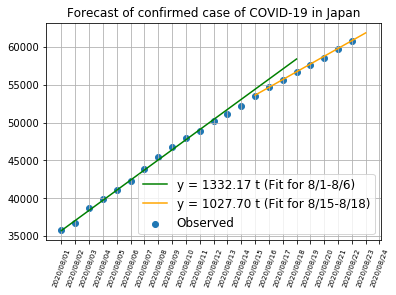

In [139]:
plt.scatter(x_latent[:len(j_confirmed_pick)], j_confirmed_pick, label="Observed")
plt.xticks(x_latent, xticks, fontsize=7, rotation=70);
draw_approx_curve(x_latent, j_confirmed_pick, range(6), 1, color="green", forecast=12, info="(Fit for 8/1-8/6)")
draw_approx_curve(x_latent, j_confirmed_pick, range(14, 18), 1, color="orange", forecast=5, info="(Fit for 8/15-8/18)")
#draw_approx_exp_curve(x_latent, j_confirmed_pick, range(10,18), color="orange", forecast=5, info="(Fit for 7/26-8/2)")

plt.legend(fontsize=12, loc="lower right")
plt.title("Forecast of confirmed case of COVID-19 in Japan")
plt.grid()

USの傾向のグラフ

USで国家非常事態宣言が出されたのは3/13。カリフォルニア州で外出禁止令が出されたのは3/20。ニューヨーク州で外出禁止令が出されたのは3/22。

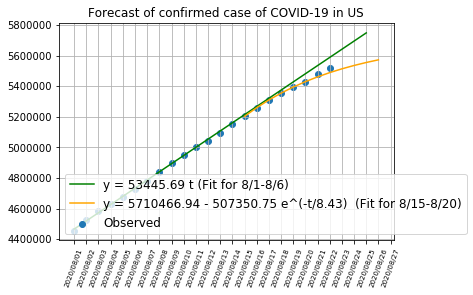

In [140]:
us_confirmed = df.USA[193:].values
plt.scatter(x_latent[:len(us_confirmed)], us_confirmed, label="Observed")
plt.xticks(x_latent, xticks, fontsize=7, rotation=70);
draw_approx_curve(x_latent, us_confirmed, range(6), 1, forecast=19, color="green", info="(Fit for 8/1-8/6)")
draw_approx_exp_curve(x_latent, us_confirmed, range(14,20), forecast=6, color="orange", info="(Fit for 8/15-8/20)")

plt.legend(fontsize=12, loc="lower left")
plt.title("Forecast of confirmed case of COVID-19 in US")
plt.grid()

各国の新規感染者数の推移

date         2020-09-04 00:00:00
USA                        67823
Germany                     3461
Japan                       1998
Singapore                    908
China                        180
France                      4688
Italy                        947
Korea                        332
dtype: object


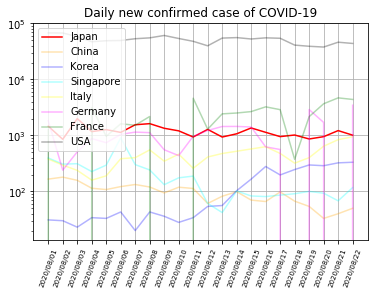

In [141]:
df_diff = df[{"China", "Japan", "Korea", "Singapore", "Italy", "Germany", "France", "USA"}].diff()
df_diff = pd.concat([df.date, df_diff], axis=1)
df_diff = df_diff[193:]

plt.plot(x_latent, df_diff["Japan"], color="red", label="Japan")
plt.plot(x_latent, df_diff["China"], color="orange", alpha=0.3, label="China")
plt.plot(x_latent, df_diff["Korea"], color="blue", alpha=0.3, label="Korea")
plt.plot(x_latent, df_diff["Singapore"], color="cyan", alpha=0.3, label="Singapore")
plt.plot(x_latent, df_diff["Italy"], color="yellow", alpha=0.3, label="Italy")
plt.plot(x_latent, df_diff["Germany"], color="magenta", alpha=0.3, label="Germany")
plt.plot(x_latent, df_diff["France"], color="green", alpha=0.3, label="France")
plt.plot(x_latent, df_diff["USA"], color="black", alpha=0.3, label="USA")

#df_new.date = [l if i%5==0 else "" for i,l in enumerate(df_new.date)]
plt.xticks(range(len(df_diff.date)-13), df_diff.date.dt.strftime("%Y/%m/%d"), fontsize=7, rotation=70);
plt.yscale("log");
plt.grid();
plt.legend(loc="upper left");
plt.title("Daily new confirmed case of COVID-19");
print(df_diff.max())


日本の新規感染者数

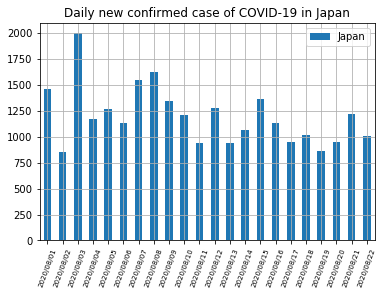

In [142]:
df_diff.Japan.dropna().plot(kind="bar")
#draw_approx_curve(np.array(range(20)), df_diff.Japan.dropna().values, range(15), 1, forecast=3, info="Fit for 7/16-7/30")
plt.xticks(range(len(df_diff.date)-13), df_diff.date.dt.strftime("%Y/%m/%d"), fontsize=7, rotation=70);
plt.grid();
plt.legend()
plt.title("Daily new confirmed case of COVID-19 in Japan");

新規感染者数が最大になってからの、毎日の感染者数の推移（割合）

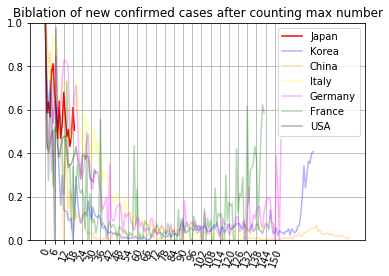

In [143]:
df_new = df[{"China", "Japan", "Korea", "Singapore", "Italy", "Germany", "France", "USA"}].diff()
indices = df_new.idxmax()

# Because China changed the method to count the case in the middle
df_new.China[indices.China] = 0
indices.China = df_new.China.idxmax()

plt.plot(df_new.Japan.dropna().values[indices.Japan-1:]/df_new.Japan[indices.Japan], color="red", label="Japan")
plt.plot(df_new.Korea.dropna().values[indices.Korea-1:]/df_new.Korea[indices.Korea], color="blue", alpha=0.3, label="Korea")
plt.plot(df_new.China.dropna().values[indices.China-1:]/df_new.China[indices.China], color="orange", alpha=0.3, label="China")
plt.plot(df_new.Italy.dropna().values[indices.Italy-1:]/df_new.Italy[indices.Italy], color="yellow", alpha=0.3, label="Italy")
plt.plot(df_new.Germany.dropna().values[indices.Germany-1:]/df_new.Germany[indices.Germany], color="magenta", alpha=0.3, label="Germany")
plt.plot(df_new.France.dropna().values[indices.France-1:]/df_new.France[indices.France], color="green", alpha=0.3, label="France")
plt.plot(df_new.USA.dropna().values[indices.USA-1:]/df_new.USA[indices.USA], color="black", alpha=0.3, label="USA")
plt.grid();
plt.xticks(range(0,151,6), rotation=70);
plt.ylim((0.,1.))
plt.legend()
plt.title("Biblation of new confirmed cases after counting max number");


## 新規感染者数

In [144]:
df_new = df[{"USA", "Japan"}].diff()
df_new = pd.concat([df["date"], df_new], axis=1)
#df_new = df_new[50:]

# 移動平均
ma7_jp = df_new.Japan.rolling(7, center=True).mean()
ma7_jp.name = "JP_MA7"
df_new = pd.concat([df_new, ma7_jp], axis=1)
ma7_us = df_new.USA.rolling(7, center=True).mean()
ma7_us.name = "US_MA7"
df_new = pd.concat([df_new, ma7_us], axis=1)

xticks = [l.strftime("%Y/%m/%d") if i%7==0 else "" for i,l in enumerate(df_new.date)]


141317.0


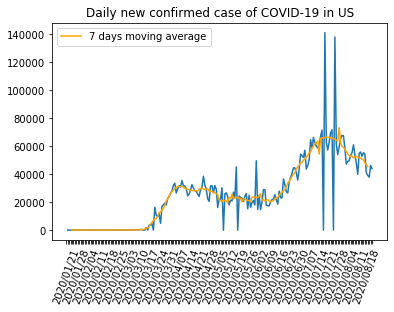

In [145]:

plt.plot(df_new.USA)
plt.plot(df_new.US_MA7, color="orange", label="7 days moving average")
#plt.xticks(range(50, 50+len(xuticks)-11), xuticks, rotation=70)
plt.xticks(range(len(xticks)-13), xticks, rotation=70)
#plt.grid()
plt.title("Daily new confirmed case of COVID-19 in US")
plt.legend()
print(max(df_new.USA.dropna()))

日本の一日の感染者数が最大だった日の人数

In [146]:
print(max(df_new.Japan.dropna()))

1998.0


日本の一日の感染者数の曜日ごとの変動幅

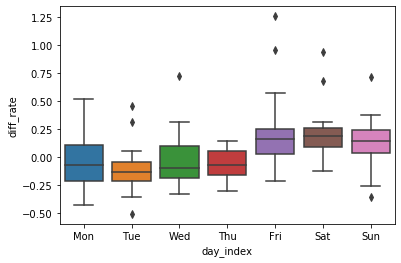

In [147]:
import seaborn as sns

# 移動平均との差分の割合
df_new["diff_rate"] = (df_new.Japan - df_new.JP_MA7)/df_new.JP_MA7
#plt.plot(df_new.diff_rate)

# 曜日インデックス
## 月曜日=0, 日曜日=6
df_new["day_index"] = df_new.date.dt.dayofweek
#plt.plot(df_new.day_index)

# 1日に50人以上の感染者数を出した日を抽出（元の数が少ないと割合を算出したときのブレが大きくなるため）
data = df_new.dropna()
data = data[data["Japan"] > 50]
#plt.plot(data.diff_rate)
#print(data.diff_rate)

# 曜日毎の傾向を箱ひげ図で表示
sns.boxplot(data=data, x="day_index", y="diff_rate")
plt.xticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]);

#df_new.Japan.hist(bins=14)

#plt.plot(df_new.Japan)
#plt.plot(df_new.MA7, color="orange")
#plt.xticks(range(len(xjticks)-10), xjticks, rotation=70)
#plt.grid()
#plt.title("Daily new confirmed case of COVID-19 in Japan");
np.median(data[data.day_index==0].Japan)
trend_day = [np.median(data[data.day_index==0].diff_rate), np.median(data[data.day_index==1].diff_rate), np.median(data[data.day_index==2].diff_rate), np.median(data[data.day_index==3].diff_rate), np.median(data[data.day_index==4].diff_rate), np.median(data[data.day_index==5].diff_rate), np.median(data[data.day_index==6].diff_rate)]
std_day = [np.std(data[data.day_index==0].diff_rate, ddof=1), np.std(data[data.day_index==1].diff_rate, ddof=1), np.std(data[data.day_index==2].diff_rate, ddof=1), np.std(data[data.day_index==3].diff_rate, ddof=1), np.std(data[data.day_index==4].diff_rate, ddof=1), np.std(data[data.day_index==5].diff_rate, ddof=1), np.std(data[data.day_index==6].diff_rate, ddof=1)]
#print(trend_day)
#print(std_day)

Text(0.5, 1.0, 'Daily new confirmed case of COVID-19 in Japan')

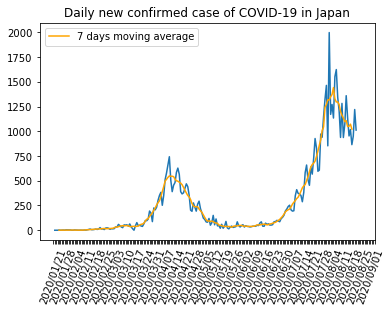

In [148]:
plt.plot(df_new.Japan.values)
plt.plot(df_new.JP_MA7.values, color="orange", label="7 days moving average")
plt.xticks(range(0, 0+len(xticks)), xticks, rotation=70)
#plt.grid()
plt.legend()
plt.title("Daily new confirmed case of COVID-19 in Japan")

## 7日間移動平均の指数関数近似

In [149]:
from collections import deque

class rolling_fit_exp:
    def __init__(self):
        self.res2 = deque()
        self.res3 = deque()

    def a(self, y):
        base = y.values[0]
        y = y.values - base
        x = range(len(y))

        # detect convex with Jensen`s low
        slope = (y[-1] - y[0])/(x[-1] - x[0])
        intercept = y[0] - slope * x[0]
        sum_slope = sum(slope * x + intercept)
        sum_obs = sum(y)

        def func(x, a, b):
            return a*(np.exp(x/b) - 1)

        try:
            if slope >= 0:
                if sum_obs < sum_slope: # Convex function
                    popt, _ = curve_fit(func, x, y, p0=(500,5))
                else: # Downward-convex function
                    popt, _ = curve_fit(func, x, y, p0=(500,-5))
            else:
                if sum_obs < sum_slope: # Convex function
                    popt, _ = curve_fit(func, x, y, p0=(-500,-5))
                else: # Downward-convex function
                    popt, _ = curve_fit(func, x, y, p0=(-500,5))
        except RuntimeError:
            popt = [0, 0, 0]

        self.res2.append(popt[1])
        self.res3.append(base - popt[0])

        return popt[0]
    
    def b(self, y):
        return self.res2.popleft()

    def c(self, y):
        return self.res3.popleft()

fe = rolling_fit_exp()
df_new[["e_a", "e_b", "e_c"]] = df_new.JP_MA7.rolling(7, center=True).agg({"e_a":fe.a, "e_b":fe.b, "e_c":fe.c})
print(df_new[70:80])

date      USA  Japan      JP_MA7        US_MA7  diff_rate  day_index  \
70 2020-03-31  17987.0   87.0  175.714286  20752.285714  -0.504878          1   
71 2020-04-01  22559.0  225.0  203.000000  22353.571429   0.108374          2   
72 2020-04-02  24103.0  206.0  225.428571  24355.285714  -0.086185          3   
73 2020-04-03  26298.0  233.0  255.428571  26380.714286  -0.087808          4   
74 2020-04-04  28103.0  303.0  279.000000  27595.857143   0.086022          5   
75 2020-04-05  32105.0  351.0  297.000000  28588.857143   0.181818          6   
76 2020-04-06  33510.0  383.0  340.571429  29675.428571   0.124581          0   
77 2020-04-07  26493.0  252.0  390.000000  30327.000000  -0.353846          1   
78 2020-04-08  29510.0  351.0  440.714286  31367.428571  -0.203566          2   
79 2020-04-09  31709.0  511.0  496.714286  31296.142857   0.028760          3   

              e_a           e_b            e_c  
70     223.074701     12.554187    -105.217558  
71     183.695192  

## 7日間移動平均のLogの1次関数近似

In [150]:
class rolling_fit:
    def __init__(self):
        self.res2 = deque()

    def a(self, y):
        intercept = y.values[0]
        y = y.values - intercept
        x = range(len(y))
        coef = np.polyfit(x, y, 1)
        coef[1] += intercept

        self.res2.append(coef[1])

        return coef[0]

    def b(self, y):
        return self.res2.popleft()

f = rolling_fit()
df_new["MA7Log"] = np.log(df_new.JP_MA7)
df_new[["a", "b"]] = df_new.MA7Log.rolling(7, center=True).agg({"a":f.a, "b":f.b})
print(df_new[70:80])

date      USA  Japan      JP_MA7        US_MA7  diff_rate  day_index  \
70 2020-03-31  17987.0   87.0  175.714286  20752.285714  -0.504878          1   
71 2020-04-01  22559.0  225.0  203.000000  22353.571429   0.108374          2   
72 2020-04-02  24103.0  206.0  225.428571  24355.285714  -0.086185          3   
73 2020-04-03  26298.0  233.0  255.428571  26380.714286  -0.087808          4   
74 2020-04-04  28103.0  303.0  279.000000  27595.857143   0.086022          5   
75 2020-04-05  32105.0  351.0  297.000000  28588.857143   0.181818          6   
76 2020-04-06  33510.0  383.0  340.571429  29675.428571   0.124581          0   
77 2020-04-07  26493.0  252.0  390.000000  30327.000000  -0.353846          1   
78 2020-04-08  29510.0  351.0  440.714286  31367.428571  -0.203566          2   
79 2020-04-09  31709.0  511.0  496.714286  31296.142857   0.028760          3   

              e_a           e_b            e_c    MA7Log         a         b  
70     223.074701     12.554187    -10

新規感染者数がe^tの指数関数と曜日毎の変動という単純な2要素のみで近似できる（実際にはそんなことはない）と仮定した外挿モデルによる、1日先予測

In [151]:
forecast = 1
#df_new["tmp"] = np.exp(df_new.a.values * 3 + df_new.b.values)
#df_new["predict"] = np.exp(df_new.a.values * (9+forecast) + df_new.b.values)
df_new["predict"] = df_new.apply(lambda d: np.exp(d.a * (9+forecast) + d.b)*(1+trend_day[d.day_index]), axis=1)
df_new["predict_u"] = df_new.apply(lambda d: np.exp(d.a * (9+forecast) + d.b)*(1+trend_day[d.day_index]+2*std_day[d.day_index]), axis=1)
df_new["predict_d"] = df_new.apply(lambda d: np.exp(d.a * (9+forecast) + d.b)*(1+trend_day[d.day_index]-2*std_day[d.day_index]), axis=1)



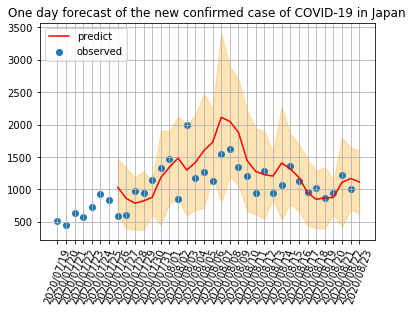

[628.8948699132926, 1115.7780959363579, 1602.6613219594233]


In [152]:
df_new_pick = df_new[180:]

#plt.plot(range(len(df_new.MA7)), df_new.MA7.values, color="green")
#plt.plot(range(len(df_new.tmp)), df_new.tmp.values, color="green", linewidth=0.5)
plt.plot(range(6+forecast, len(df_new_pick.predict)+6+forecast), df_new_pick.predict, color="red", label="predict")
plt.fill_between(range(6+forecast, len(df_new_pick.predict)+6+forecast), df_new_pick.predict_d, df_new_pick.predict_u, color="orange", alpha=0.3)
plt.scatter(range(len(df_new_pick.Japan)), df_new_pick.Japan.values, label="observed")

xjticks = [l.strftime("%Y/%m/%d") for i,l in enumerate(df_new_pick.date)]
plt.xticks(range(len(xjticks)-12), xjticks, rotation=70)
plt.grid()
plt.legend(loc="upper left");
plt.title("One day forecast of the new confirmed case of COVID-19 in Japan")
plt.show()
print([df_new_pick.predict_d.iloc[-8-12], df_new_pick.predict.iloc[-8-12], df_new_pick.predict_u.iloc[-8-12]])
#print(df_new_pick.predict_u)

## 以下 Obsolete （以前は使っていたけれど、もう使っていないグラフたち）

累積感染者数が15,000人を超えてから10日間の経過

Text(0.5, 1.0, 'Numbers of the day after counting 10,000 cases')

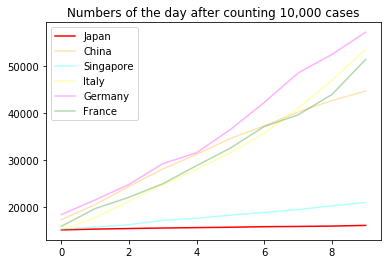

In [153]:
plt.plot(range(10), df[df["Japan"] > 15000]["Japan"][:10], color="red", label="Japan")
plt.plot(range(10), df[df["China"] > 15000]["China"][:10], color="orange", alpha=0.3, label="China")
#plt.plot(range(10), df[df["Korea"] > 15000]["Korea"][:10], color="blue", alpha=0.3, label="Korea")
plt.plot(range(10), df[df["Singapore"] > 15000]["Singapore"][:10], color="cyan", alpha=0.3, label="Singapore")
plt.plot(range(10), df[df["Italy"] > 15000]["Italy"][:10], color="yellow", alpha=0.3, label="Italy")
plt.plot(range(10), df[df["Germany"] > 15000]["Germany"][:10], color="magenta", alpha=0.3, label="Germany")
plt.plot(range(10), df[df["France"] > 15000]["France"][:10], color="green", alpha=0.3, label="France")
#plt.plot(range(10), df[df["USA"] > 15000]["USA"][:10], color="black", alpha=0.3, label="USA")

plt.legend()
plt.title("Numbers of the day after counting 10,000 cases")

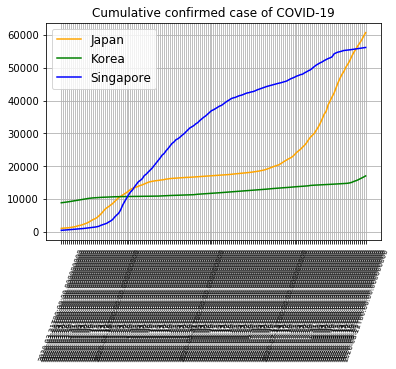

In [154]:
plt.plot(df.Japan.dropna().values[60:], color="orange", label="Japan")
plt.plot(df.Korea.dropna().values[60:], color="green", label="Korea")
plt.plot(df.Singapore.dropna().values[60:], color="blue", label="Singapore")
plt.xticks(range(len(df.Japan.dropna().values[60:])), df.date.dropna().values[60:], fontsize=7, rotation=70);

plt.legend(fontsize=12)
plt.title("Cumulative confirmed case of COVID-19")
plt.grid()

日本の新規感染者の推移予測（季節調整ARIMAモデル）

SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -125.040
Date:                Sun, 23 Aug 2020   AIC                            256.079
Time:                        08:38:19   BIC                            259.213
Sample:                             0   HQIC                           256.759
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9540      0.078     12.226      0.000       0.801       1.107
ma.L1          0.5463      0.334      1.637      0.102      -0.108       1.200
sigma2      7325.3861   3062.013      2.392      0.017    1323.951    1.33e+04
Ljun

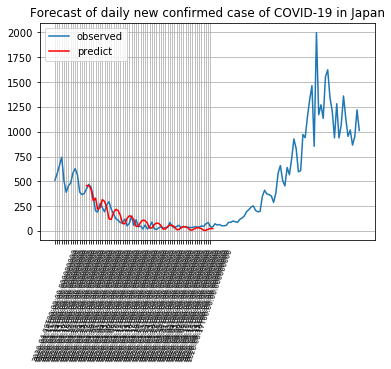

In [155]:
import statsmodels.api as sm

df_new = df[{"Japan"}].diff()
df_new = pd.concat([df["date"], df_new], axis=1)
df_new = df_new[79:]

ts = df_new.Japan.dropna().values[:21]
#print(sm.tsa.arma_order_select_ic(ts, ic='aic', trend="c"))

#SARIMA_2_0_0_7 = sm.tsa.SARIMAX(ts, order=(2,0,0), seasonal_order=(0,0,1,7)).fit()
#print(SARIMA_2_0_0_7.summary())

#SARIMA_1_0_0_7 = sm.tsa.SARIMAX(ts, order=(1,0,0), seasonal_order=(1,0,1,7)).fit()
#print(SARIMA_1_0_0_7.summary())

SARIMA_1_0_1 = sm.tsa.SARIMAX(ts, order=(1,0,1)).fit()
print(SARIMA_1_0_1.summary())

SARIMA_1_0_1_6 = sm.tsa.SARIMAX(ts, order=(1,0,1), seasonal_order=(1,0,0,6)).fit()
print(SARIMA_1_0_1_6.summary())

SARIMA_1_0_0_6 = sm.tsa.SARIMAX(ts, order=(1,0,0), seasonal_order=(1,0,0,6)).fit()
print(SARIMA_1_0_0_6.summary())

#resid = SARIMA_1_0_0_6.resid
#sm.graphics.tsa.plot_acf(resid)
#sm.graphics.tsa.plot_pacf(resid)

predict = SARIMA_1_0_0_6.predict(14,70)

plt.plot(df_new.Japan.dropna().values, label="observed")
plt.plot(range(14, 71), predict, color="red", label="predict")
plt.xticks(range(70), df_new.date.values[:70], fontsize=7, rotation=70);
plt.legend()
plt.grid()
plt.title("Forecast of daily new confirmed case of COVID-19 in Japan");
